# Creating the Initial Conditions

This notebook creates the initial conditions files for two grid resolutions: 1-deg and 0.5-deg

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
import time

Next, define the location of the input directory for the model. This is the same directory that holds the bathymetry file generated in the previous notebooks for this model example.

In [2]:
# define the input directory
input_dir = '/home/tara/Documents/SJSU/CS_185C/Project/input'

## Constructing the Initial Conditions
For my model, I will use a model state from the ECCO Version 5 state estimate. I will prepare the initial condition fields in 7 steps:
1. download 5 fields and 4 grid files generated by the ECCO model in 2008
2. read the ECCO model grid
3. read in the bathymetry for my model as well as its grid
4. prepare the ECCO fields for interpolation
5. interpolate the ECCO fields onto my model grid and store each as a binary file
6. plot the interpolated fields to ensure they look as expected
7. prepare notes on the run-time options I will use to implement my initial condition approach

### Step 1: Download the ECCO fields
To begin, I downloaded the model fields generated by the ECCO Version 5 Alpha state estimate. These fields are available [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/nctiles_monthly). In particular, I downloaded the following list of files that contain the field pertaining to starting point of my model (January 2008):

| Variable | File Name |
| -------- | --------- |
|THETA|THETA/THETA_2008.nc|
|SALT|SALT/SALT_2008.nc|
|UVEL|UVELMASS/UVELMASS_2008.nc|
|VVEL|VVELMASS/VVELMASS_2008.nc|
|ETAN|ETHAN/ETAN_2008.nc|

I stored these fields in the following directory:

In [3]:
data_folder = '/home/tara/Documents/SJSU/CS_185C/data'

### Step 2: Read in the ECCO grid
To read in the ECCO fields, I will rely on the `grid` module from the `eccoseas.ecco` package [HERE](https://github.com/mhwood/eccoseas), which I import here:

In [4]:
import os
import sys

sys.path.append('/home/tara/Documents/SJSU/CS_185C/lectures/lecture10_2/')

from eccoseas.ecco import grid

In [12]:
coarse_ecco_XC_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='XC')
coarse_ecco_YC_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='YC')
coarse_ecco_hFacC_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacC')
coarse_ecco_hFacW_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacW')
coarse_ecco_hFacS_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacS')
coarse_ecco_RF_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='RF')

medium_ecco_XC_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='XC')
medium_ecco_YC_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='YC')
medium_ecco_hFacC_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacC')
medium_ecco_hFacW_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacW')
medium_ecco_hFacS_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacS')
medium_ecco_RF_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='RF')

As described [HERE](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Plotting_Tiles.html), the ECCO grid has 13 tiles

### Step 3: Read in the Model Grid and Generate a Mask
Here, I will recreate the grid I will use in my model and read in the bathymetry file (see previous notebooks for details):

In [7]:
# COARSE GRID PARAMS
delX_coarse, delY_coarse = 1, 1
n_cols_coarse, n_rows_coarse = 360, 180

# MED GRID PARAMS
delX_medium, delY_medium = 1/2, 1/2
n_cols_medium, n_rows_medium = 720, 360

xgOrigin, ygOrigin = -180, -90

def get_xc_yc(delX, delY, n_cols, n_rows, xgOrigin, ygOrigin):
    xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
    yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY, delY)
    XC, YC = np.meshgrid(xc, yc)

    print('Double check shape:', np.shape(xc)[0], 'x' , np.shape(yc)[0])
    print('Number of grid cells:', n_cols*n_rows)
    return xc, yc, XC, YC

print('COARSE GRID')
xc_coarse, yc_coarse, XC_coarse, YC_coarse = get_xc_yc(delX_coarse, delY_coarse, n_cols_coarse, n_rows_coarse, xgOrigin, ygOrigin)
bathy_coarse = np.fromfile(os.path.join(input_dir,'global_bathymetry_1_deg.bin'),'>f4').reshape(np.shape(XC_coarse))

print('\nMED GRID')
xc_medium, yc_medium, XC_medium, YC_medium = get_xc_yc(delX_medium, delY_medium, n_cols_medium, n_rows_medium, xgOrigin, ygOrigin)
bathy_medium = np.fromfile(os.path.join(input_dir,'global_bathymetry_half_deg.bin'),'>f4').reshape(np.shape(XC_medium))

COARSE GRID
Double check shape: 360 x 180
Number of grid cells: 64800

MED GRID
Double check shape: 720 x 360
Number of grid cells: 259200


With an eye toward the interpolation to come next, I will make a mask to determine where the interpolatation will take place. I will create this mask by recreating the `hFac` field for my model using the `hFac` module from the `eccoseas` package: 

In [8]:
from eccoseas.downscale import hFac

In [ ]:
delR = np.array([10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.01,
                    10.03, 10.11, 10.32, 10.80, 11.76, 13.42, 16.04, 19.82, 24.85,
                    31.10, 38.42, 46.50, 55.00, 63.50, 71.58, 78.90, 85.15, 90.18,
                    93.96, 96.58, 98.25, 99.25,100.01,101.33,104.56,111.33,122.83,
                    139.09,158.94,180.83,203.55,226.50,249.50,272.50,295.50,318.50,
                    341.50,364.50,387.50,410.50,433.50,456.50])

def create_hFacC(depth, delR):
    hFacC = hFac.create_hFacC_grid(depth, delR)
    return hFacC

hFacC_coarse = create_hFacC(bathy_coarse, delR)
hFacC_medium = create_hFacC(bathy_medium, delR)

The mask is generated by setting all of the non-zero `hFac` points to 1:

In [10]:
def make_mask(hFacC):
    mask = np.copy(hFacC)
    mask[mask>0] = 1
    return mask

mask_coarse = make_mask(hFacC_coarse)
mask_medium = make_mask(hFacC_medium)

To double check the mask was created as expected, I will plot it in comparison to the bathymetry here:

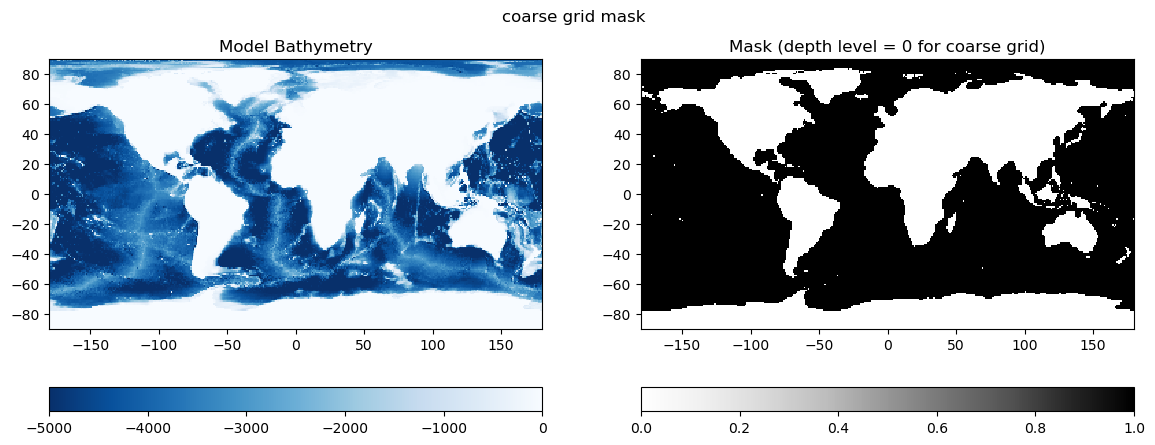

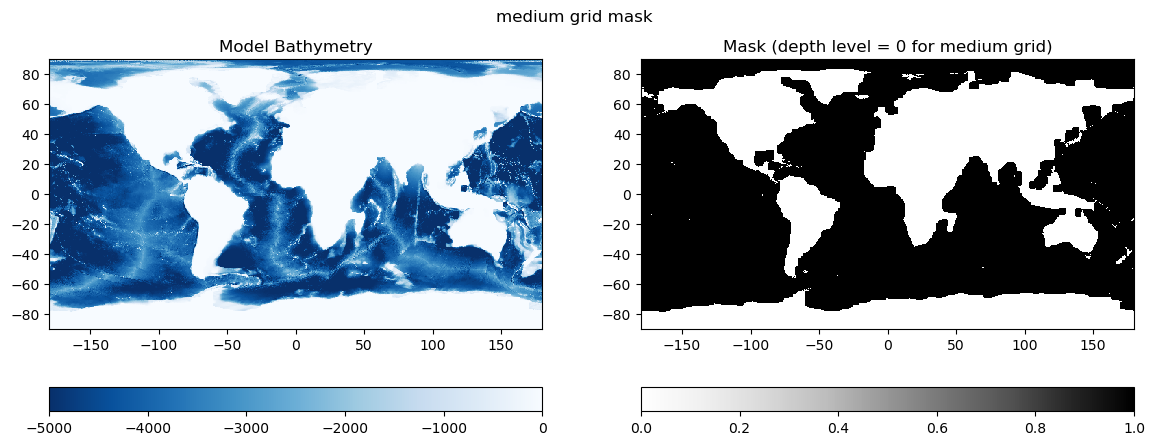

In [14]:
def vis_mask(bathy, mask, XC, YC, res):

    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    C = plt.pcolormesh(XC, YC, bathy, vmin=-5000, vmax=0, cmap='Blues_r')
    plt.colorbar(C, orientation = 'horizontal')
    plt.title('Model Bathymetry')

    depth_level = 0
    plt.subplot(1,2,2)
    C = plt.pcolormesh(XC, YC, mask[0], vmin=0, vmax=1, cmap='Greys')
    plt.colorbar(C, orientation = 'horizontal')
    plt.title(f'Mask (depth level = {str(depth_level)} for {res} grid)')

    plt.suptitle(f'{res} grid mask')

    plt.show()

vis_mask(bathy_coarse, mask_coarse, XC_coarse, YC_coarse, 'coarse')
vis_mask(bathy_medium, mask_medium, XC_medium, YC_medium, 'medium')

Seems reasonable!

### Step 4: Prepare the grids for interpolation


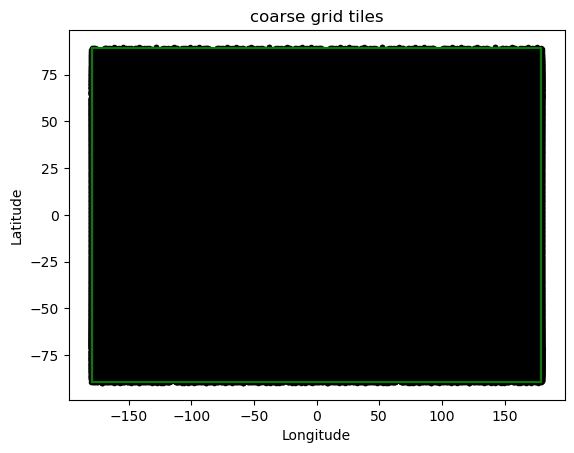

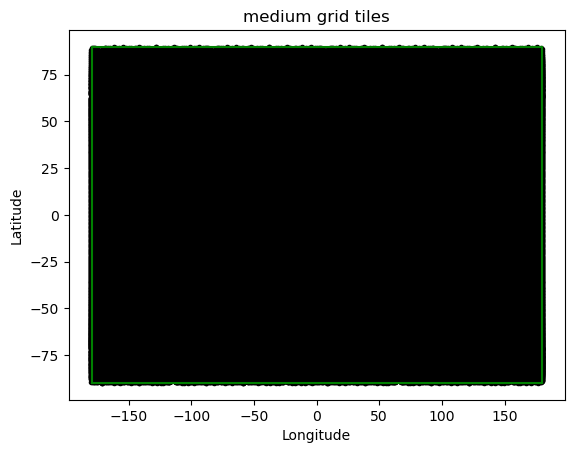

In [15]:
def viz_tiles(XC, YC, ecco_XC_tiles, ecco_YC_tiles, res):
    for i in range(1,14):
        plt.plot(ecco_XC_tiles[i],ecco_YC_tiles[i],'k.')

    plt.plot(XC[:,0],YC[:,0], 'g-')
    plt.plot(XC[:,-1],YC[:,-1], 'g-')
    plt.plot(XC[0,:],YC[0,:], 'g-')
    plt.plot(XC[-1,:],YC[-1,:], 'g-')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.title(f'{res} grid tiles')

    plt.show()

viz_tiles(XC_coarse, YC_coarse, coarse_ecco_XC_tiles, coarse_ecco_YC_tiles, 'coarse')
viz_tiles(XC_medium, YC_medium, medium_ecco_XC_tiles, medium_ecco_YC_tiles, 'medium')

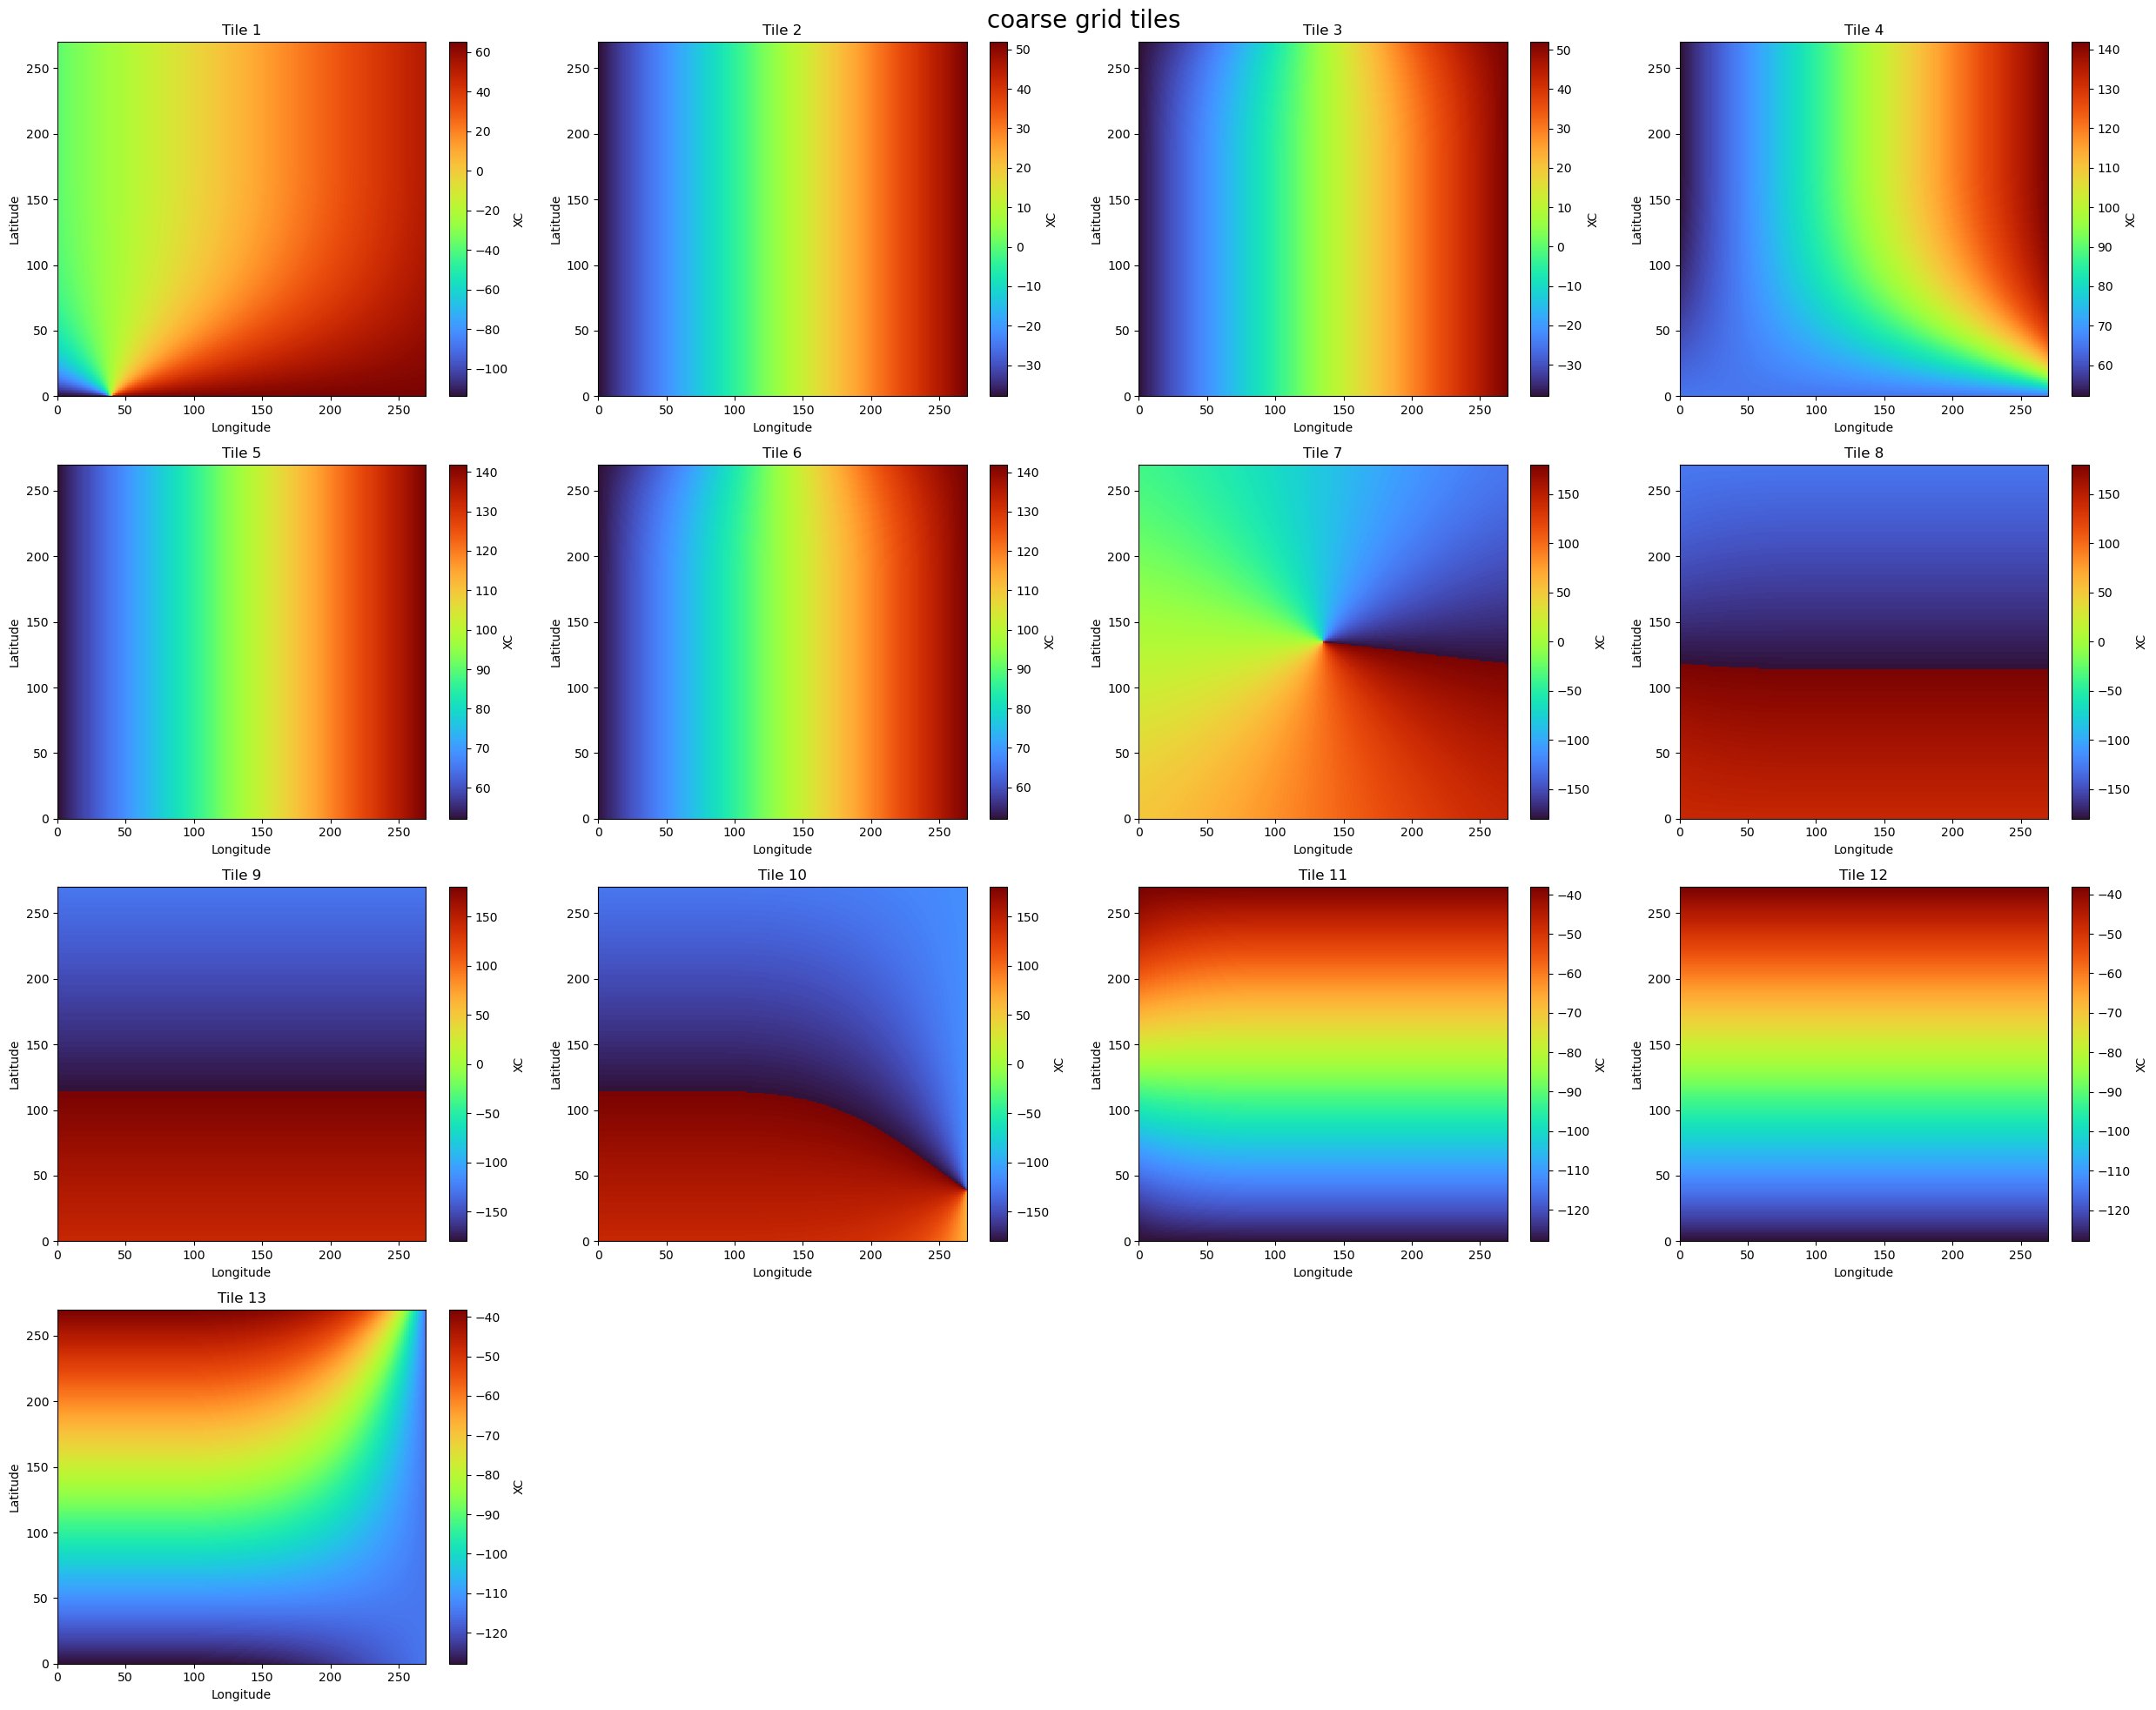

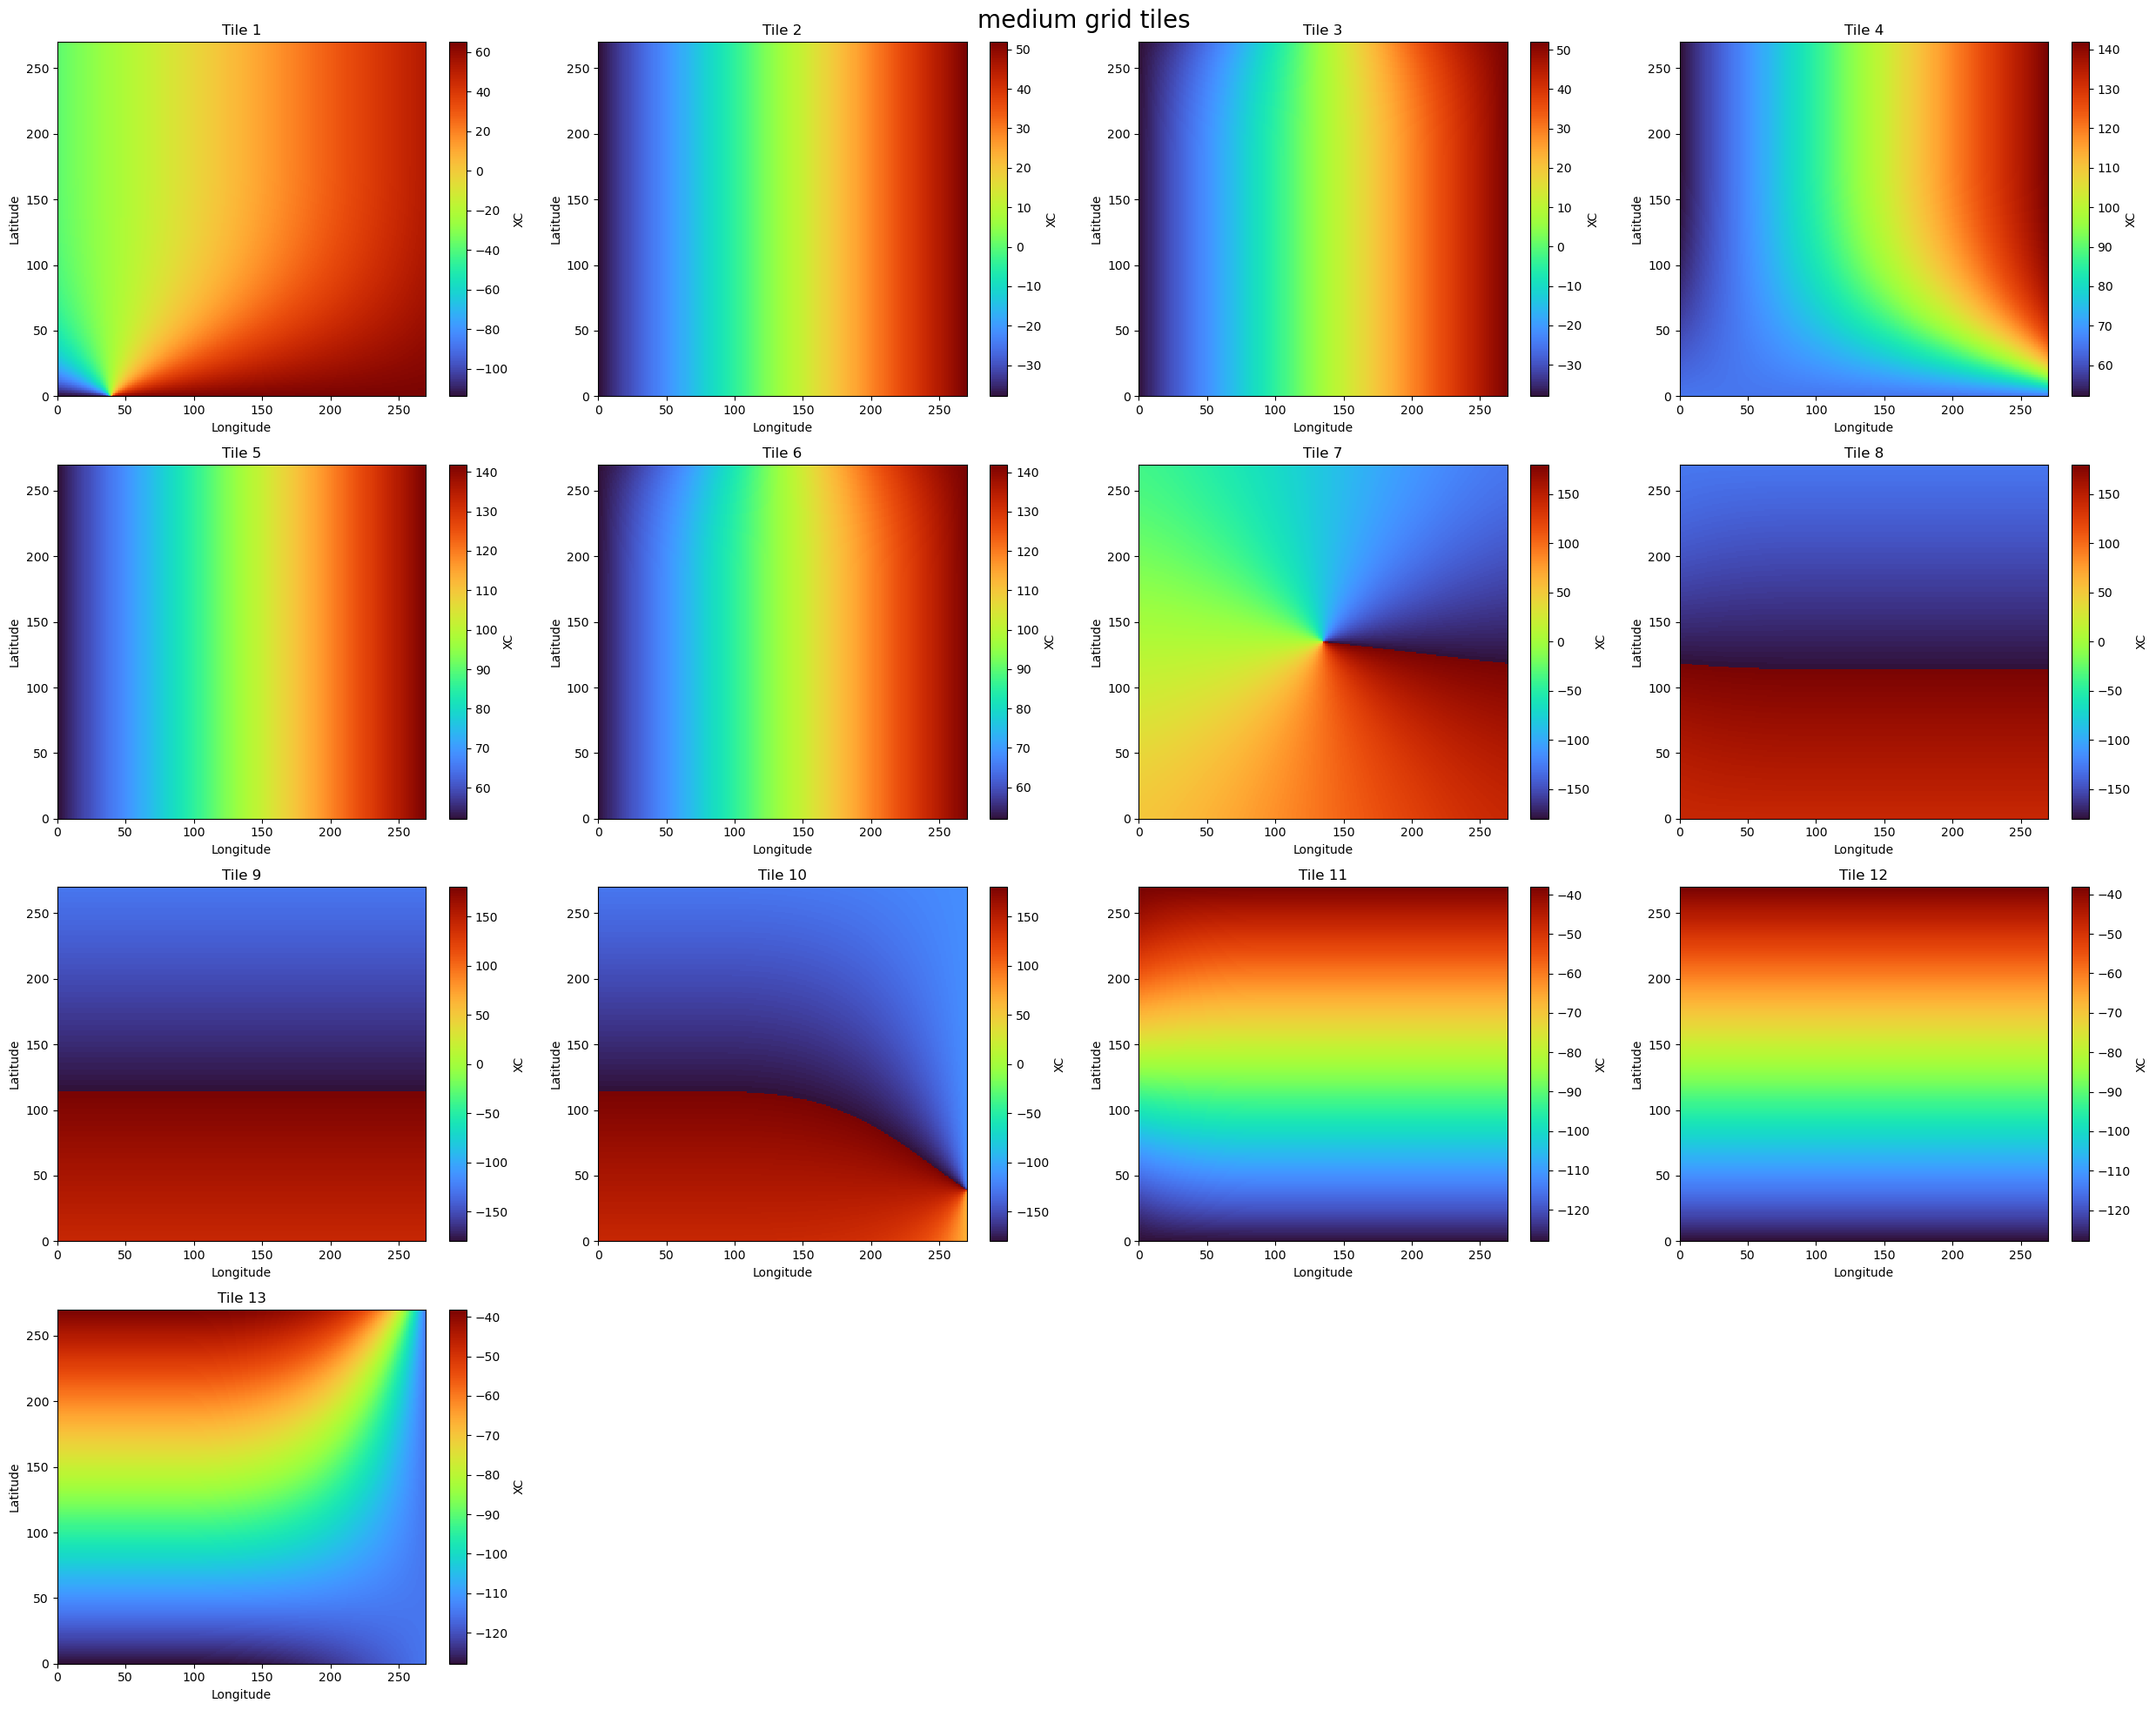

In [16]:
def check_tiles(ecco_XC_tiles, res):
    fig, axes = plt.subplots(4, 4, figsize=(25, 20))
    axes = axes.flatten()

    for i in range(13):
        ax = axes[i]
        ax.set_title(f'Tile {i+1}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        
        C = ax.pcolormesh(ecco_XC_tiles[i+1], cmap='turbo')
        fig.colorbar(C, ax=ax, orientation='vertical', label='XC')

    for j in range(13, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f'{res} grid tiles', fontsize=20)  

    plt.tight_layout()
    plt.show()

check_tiles(coarse_ecco_XC_tiles, 'coarse')
check_tiles(medium_ecco_XC_tiles, 'medium')

In [19]:
tile_list = [1,2,3,4,5,6,7,8,9,10,11,12,13]
def prep_grids(ecco_RF_tiles, ecco_XC_tiles, ecco_YC_tiles, ecco_hFacC_tiles, ecco_hFacW_tiles, ecco_hFacS_tiles):

    # determine the number of points in each set
    total_points = 0
    for tile_number in tile_list:
        total_points += np.size(ecco_XC_tiles[tile_number])

    # make empty arrays to fill in
    ecco_XC_points = np.zeros((total_points, ))
    ecco_YC_points = np.zeros((total_points, ))
    ecco_hFacC_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
    ecco_hFacW_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
    ecco_hFacS_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
    ecco_mask_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))

    # loop through the tiles and fill in the XC, YC, and mask points for interpolation
    points_counted = 0
    for tile_number in tile_list:
        tile_N = np.size(ecco_XC_tiles[tile_number])
        
        ecco_XC_points[points_counted:points_counted+tile_N] = ecco_XC_tiles[tile_number].ravel()
        ecco_YC_points[points_counted:points_counted+tile_N] = ecco_YC_tiles[tile_number].ravel()
        
        for k in range(np.size(ecco_RF_tiles[tile_number])):
            level_hFacC = ecco_hFacC_tiles[tile_number][k, :, :]
            level_hFacW = ecco_hFacW_tiles[tile_number][k, :, :]
            level_hFacS = ecco_hFacS_tiles[tile_number][k, :, :]
            level_mask = np.copy(level_hFacC)
            level_mask[level_mask>0] = 1
            ecco_hFacC_points[k, points_counted:points_counted+tile_N] = level_hFacC.ravel()
            ecco_hFacW_points[k, points_counted:points_counted+tile_N] = level_hFacW.ravel()
            ecco_hFacS_points[k, points_counted:points_counted+tile_N] = level_hFacS.ravel()
            ecco_mask_points[k,points_counted:points_counted+tile_N] = level_mask.ravel()
        
        points_counted += tile_N
    return ecco_XC_points, ecco_YC_points, ecco_hFacC_points, ecco_hFacW_points, ecco_hFacS_points, ecco_mask_points

print('Starting Coarse Grid Prep')
ecco_XC_points_coarse, ecco_YC_points_coarse, ecco_hFacC_points_coarse, ecco_hFacW_points_coarse, ecco_hFacS_points_coarse, ecco_mask_points_coarse = prep_grids(coarse_ecco_RF_tiles, coarse_ecco_XC_tiles, coarse_ecco_YC_tiles, coarse_ecco_hFacC_tiles, coarse_ecco_hFacW_tiles, coarse_ecco_hFacS_tiles)

print('Starting Medium Grid Prep')
ecco_XC_points_medium, ecco_YC_points_medium, ecco_hFacC_points_medium, ecco_hFacW_points_medium, ecco_hFacS_points_medium, ecco_mask_points_medium = prep_grids(medium_ecco_RF_tiles, medium_ecco_XC_tiles, medium_ecco_YC_tiles, medium_ecco_hFacC_tiles, medium_ecco_hFacW_tiles, medium_ecco_hFacS_tiles)

Starting Coarse Grid Prep
Starting Medium Grid Prep


Next, we'll read in the real data fields and apply the modifications. First, create a dictionary to store the file names:

In [18]:
# make a file dictionary to loop over

# # test dictionary
file_prefix_dict = {'ETAN':'ETAN_2008.nc'}

# once tested with the above dict, run and comment with this one
# file_prefix_dict = {'ETAN':'ETAN_2008.nc',
#                     'THETA':'THETA_2008.nc',
#                     'SALT':'SALT_2008.nc',
#                     'UVEL':'UVELMASS_2008.nc',
#                     'VVEL':'VVELMASS_2008.nc'
#                     }
variable_names = list(file_prefix_dict.keys())

Now, read the initial condition fields from the same tiles:

In [20]:
def init_fields_from_tiles(data_folder, file_prefix_dict, tile_list, ecco_RF_tiles, ecco_hFacW_points, ecco_hFacS_points):

    # make a list to hold all of the ECCO grids
    init_grids = []

    # loop through each variable to read in the grid
    for variable_name in variable_names:
        
        if variable_name == 'ETAN':
            ds = nc4.Dataset(os.path.join(data_folder,file_prefix_dict[variable_name]))
            grid = ds.variables[variable_name][:,:,:,:]
            ds.close()
        elif 'VEL' in variable_name:
            ds = nc4.Dataset(os.path.join(data_folder,'UVELMASS_2008.nc'))
            u_grid = ds.variables['UVELMASS'][:,:,:,:,:]
            ds.close()
            ds = nc4.Dataset(os.path.join(data_folder,'VVELMASS_2008.nc'))
            v_grid = ds.variables['VVELMASS'][:,:,:,:,:]
            ds.close()
        else:
            ds = nc4.Dataset(os.path.join(data_folder,file_prefix_dict[variable_name]))
            grid = ds.variables[variable_name][:,:,:,:,:]
            ds.close()
        
        # create a grid of zeros to fill in
        N = np.shape(grid)[-1]*np.shape(grid)[-2]
        if variable_name == 'ETAN':
            init_grid = np.zeros((1, N*len(tile_list)))
        else:
            init_grid = np.zeros((np.size(ecco_RF_tiles[1]), N*len(tile_list)))

        # loop through the tiles
        points_counted = 0
        for tile_number in tile_list:
            if variable_name == 'ETAN':
                init_grid[0,points_counted:points_counted+N] = \
                    grid[0, tile_number-1, :, :].ravel()
            elif 'VEL' in variable_name: # when using velocity, need to consider the tile rotations
                if variable_name == 'UVEL':
                    if tile_number<7:
                        for k in range(np.size(ecco_RF_tiles[1])):
                            init_grid[k,points_counted:points_counted+N] = \
                                u_grid[0, k, tile_number-1, :, :].ravel()
                    else:
                        for k in range(np.size(ecco_RF_tiles[1])):
                            init_grid[k,points_counted:points_counted+N] = \
                                v_grid[0, k, tile_number-1, :, :].ravel()
                if variable_name == 'VVEL':
                    if tile_number<7:
                        for k in range(np.size(ecco_RF_tiles[1])):
                            init_grid[k,points_counted:points_counted+N] = \
                                v_grid[0, k, tile_number-1, :, :].ravel()
                    else:
                        for k in range(np.size(ecco_RF_tiles[1])):
                            init_grid[k,points_counted:points_counted+N] = \
                                -1*u_grid[0, k, tile_number-1, :, :].ravel()
            else:
                for k in range(np.size(ecco_RF_tiles[1])):
                    init_grid[k,points_counted:points_counted+N] = \
                        grid[0, k, tile_number-1, :, :].ravel()
            points_counted += N

        # apply some corrections
        if variable_name == 'UVEL':
            for k in range(np.size(ecco_RF_tiles[1])):
                non_zero_indices = ecco_hFacW_points[k,:]!=0
                init_grid[k,non_zero_indices] = init_grid[k,non_zero_indices]/(ecco_hFacW_points[k,non_zero_indices])
        if variable_name == 'VVEL':
            for k in range(np.size(ecco_RF_tiles[1])):
                non_zero_indices = ecco_hFacS_points[k,:]!=0
                init_grid[k,non_zero_indices] = init_grid[k,non_zero_indices]/(ecco_hFacS_points[k,non_zero_indices])
        
        init_grids.append(init_grid)

    return init_grids

print('Starting Coarse Grid Init')
init_grids_coarse = init_fields_from_tiles(data_folder, file_prefix_dict, tile_list, coarse_ecco_RF_tiles, ecco_hFacW_points_coarse, ecco_hFacS_points_coarse)

print('Starting Medium Grid Init')
init_grids_medium = init_fields_from_tiles(data_folder, file_prefix_dict, tile_list, medium_ecco_RF_tiles, ecco_hFacW_points_medium, ecco_hFacS_points_medium)

Starting Coarse Grid Init
Starting Medium Grid Init


### Step 5: Interpolate the Fields onto the Model Grid
Next, I will interpolate the ECCO external fields I read in onto my model domain. I will use the `horizonal` module from the `eccoseas` package to accomplish this interpolation.

In [21]:
from eccoseas.downscale import horizontal

In [ ]:
# Non-parallel version

# starttime = time.time()

# # loop through each variable and corresponding ECCO grid
# for variable_name, init_grid in zip(variable_names, init_grids):
#     file_start = time.time()

#     # print a message to keep track of which variable we are working on
#     # uncomment to use
#     print('    - Interpolating the '+variable_name+' grid')

#     if variable_name == 'ETAN':
#         model_mask = mask[:1,:,:]
#     else:
#         model_mask = mask

#     interpolated_grid = horizontal.downscale_3D_points(np.column_stack([ecco_XC_points, ecco_YC_points]),
#                                                        init_grid, ecco_mask_points, 
#                                                        XC, YC, model_mask)

#     # output the interpolated grid
#     output_file = os.path.join(input_dir,variable_name+'_IC.bin')
#     interpolated_grid.ravel('C').astype('>f4').tofile(output_file)

#     elapsed_time = (time.time() - file_start) / 60  # Calculate elapsed time in minutes
#     print(f'          - {elapsed_time:.2f} mins')

# total_elapsed_time = (time.time() - starttime) / 60
# print(f'Total elapsed time: {total_elapsed_time:.2f} mins')

In [ ]:
import concurrent.futures
import time
import os
import numpy as np

def process_variable(variable_name, init_grid, mask, ecco_XC_points, ecco_YC_points, ecco_mask_points, XC, YC, input_dir, res):
    file_start = time.time()

    print('    - Interpolating the ' + variable_name + ' grid')

    if variable_name == 'ETAN':
        model_mask = mask[:1, :, :]
    else:
        model_mask = mask

    interpolated_grid = horizontal.downscale_3D_points(np.column_stack([ecco_XC_points, ecco_YC_points]),
                                                       init_grid, ecco_mask_points,
                                                       XC, YC, model_mask)

    output_dir = os.path.join(input_dir, res)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    output_file = os.path.join(output_dir, variable_name + '_IC.bin')    
    interpolated_grid.ravel('C').astype('>f4').tofile(output_file)

    elapsed_time = (time.time() - file_start) / 60  # Calculate elapsed time in minutes
    print(f'          - {elapsed_time:.2f} mins')

    return elapsed_time


def run_interpolation(variable_names, init_grids, mask, ecco_XC_points, ecco_YC_points, ecco_mask_points, XC, YC, input_dir, res):
    # starttime = time.time()

    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = [executor.submit(process_variable, variable_name, init_grid, mask, ecco_XC_points, ecco_YC_points, ecco_mask_points, XC, YC, input_dir, res)
                for variable_name, init_grid in zip(variable_names, init_grids)]

        total_elapsed_time = max(f.result() for f in concurrent.futures.as_completed(futures))

    print(f'Total elapsed time: {total_elapsed_time:.2f} mins')

print('Starting Coarse Grid Interpolation')
run_interpolation(variable_names, init_grids_coarse, mask_coarse, ecco_XC_points_coarse, ecco_YC_points_coarse, ecco_mask_points_coarse, XC_coarse, YC_coarse, input_dir, 'coarse')

print('Starting Medium Grid Interpolation')
run_interpolation(variable_names, init_grids_medium, mask_medium, ecco_XC_points_medium, ecco_YC_points_medium, ecco_mask_points_medium, XC_medium, YC_medium, input_dir, 'medium')

    - Interpolating the ETAN grid
          - 0.09 mins
Total elapsed time: 0.09 mins
    - Interpolating the ETAN grid
          - 0.10 mins
Total elapsed time: 0.10 mins


### Step 6: Plotting the External Forcing Fields
Now that the fields have been generated, I will plot them to ensure they look as expected. First, I'll generate some metadata for each one:

In [26]:
meta_dict = {'ETAN':[0.1, 0.7, 'viridis', 'm'],
            'THETA':[0, 32, 'turbo', 'm'],
            'SALT':[32, 37, 'viridis', 'm'],
            'UVEL':[-0.5, 0.5, 'seismic', 'm'],
            'VVEL':[-0.5, 0.5, 'seismic', 'm']
            }

Then, I'll create all of the subplots:

Plotting Coarse Grid Initial Conditions
1
ETAN | (180, 360)


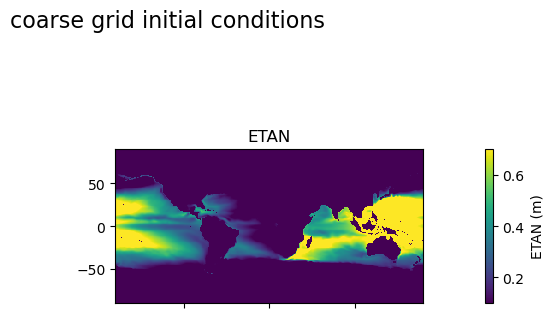

Plotting Medium Grid Initial Conditions
1
ETAN | (360, 720)


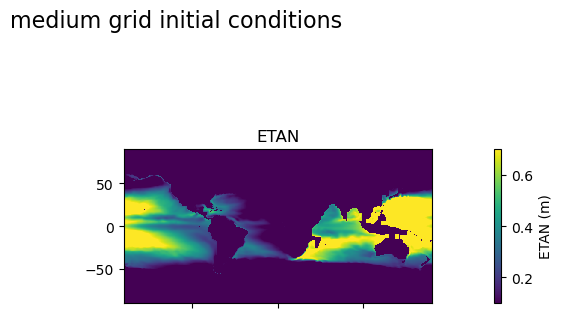

In [47]:
def plot_init_conds(input_dir, variable_names, XC, YC, delR, meta_dict, res):

    # number of elements in input_dir
    num_plots = len(variable_names)
    print(num_plots)

    fig = plt.figure(figsize=(16,4+10*num_plots))

    for i in range(len(variable_names)):
        variable_name = variable_names[i]
        
        GBL_init_grid = np.fromfile(os.path.join(input_dir, res ,variable_name+'_IC.bin'),'>f4')

        if variable_name == 'ETAN':
            GBL_init_grid = GBL_init_grid.reshape((np.shape(XC)[0], np.shape(XC)[1]))
            # print the size of the grid
            print(f'{variable_name} | {np.shape(GBL_init_grid)}')
        else:
            GBL_init_grid = GBL_init_grid.reshape((np.shape(delR)[0],np.shape(XC)[0], np.shape(XC)[1]))
            GBL_init_grid = GBL_init_grid[10, :, :] # choose just the surface for plotting
            print(f'{variable_name} | {np.shape(GBL_init_grid)}')
        
        plt.subplot(6,1,i+1)
        C = plt.pcolormesh(XC, YC, GBL_init_grid,
                        vmin=meta_dict[variable_names[i]][0],
                        vmax=meta_dict[variable_names[i]][1],
                        cmap=meta_dict[variable_names[i]][2])
        plt.colorbar(C, label=variable_names[i]+' ('+meta_dict[variable_names[i]][3]+')',fraction=0.26)

        plt.gca().set_aspect('equal', adjustable='box')

        if i<5:
            plt.gca().set_xticklabels([])
        else:
            plt.gca().set_xlabel('Longitude')
        if i%2==1:
            plt.gca().set_yticklabels([])
        if i==7:
            plt.gca().axis('off')
        if i==2:
            plt.gca().set_ylabel('Latitude')
        plt.title(variable_name)

    plt.suptitle(f'{res} grid initial conditions', fontsize=16)

    # plt.tight_layout()

    plt.show()

print('Plotting Coarse Grid Initial Conditions')
plot_init_conds(input_dir, variable_names, XC_coarse, YC_coarse, delR, meta_dict, 'coarse')

print('Plotting Medium Grid Initial Conditions')
plot_init_conds(input_dir, variable_names, XC_medium, YC_medium, delR, meta_dict, 'medium')

Looks good! Now we need to make our external forcing and boundary conditions before we're ready to run the model.

### Step 7: Run-time considerations
To use the grids as initial conditions in the model, I will specify them as "hydrography" conditions. Specifically, I will add the following lines to `PARM05` of the data file:

```
hydrogThetaFile = 'THETA_IC.bin',
hydrogSaltFile = 'SALT_IC.bin',
uVelInitFile = 'UVEL_IC.bin',
vVelInitFile = 'VVEL_IC.bin',
pSurfInitFile = 'ETAN_IC.bin',
```

In [50]:
# Check the grid sizes:

def check_grid_sizes(input_dir, variable_names, XC, delR, res):
    for i in range(len(variable_names)):
        variable_name = variable_names[i]
        
        GBL_init_grid = np.fromfile(os.path.join(input_dir,res, variable_name+'_IC.bin'),'>f4')
        print(os.path.join(input_dir, res, variable_name+'_IC.bin'))

        if variable_name == 'ETAN':
            GBL_init_grid = GBL_init_grid.reshape((np.shape(XC)[0], np.shape(XC)[1]))
        else:
            GBL_init_grid = GBL_init_grid.reshape((np.shape(delR)[0],np.shape(XC)[0], np.shape(XC)[1]))
            GBL_init_grid = GBL_init_grid[10, :, :] # choose just the surface for plotting

        print(f'{variable_name} grid size: {np.shape(GBL_init_grid)}')

print('Checking Coarse Grid Sizes')
check_grid_sizes(input_dir, variable_names, XC_coarse, delR, 'coarse')

print('\nChecking Medium Grid Sizes')
check_grid_sizes(input_dir, variable_names, XC_medium, delR, 'medium')

        

Checking Coarse Grid Sizes
/home/tara/Documents/SJSU/CS_185C/Project/input/coarse/ETAN_IC.bin
ETAN grid size: (180, 360)

Checking Medium Grid Sizes
/home/tara/Documents/SJSU/CS_185C/Project/input/medium/ETAN_IC.bin
ETAN grid size: (360, 720)
